# HRV Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values, get_time_domain_features
# Check if these funtions apply to rodents - https://github.com/jctan05/hrvanalysis/tree/master/hrvanalysis
from scipy.signal import butter, lfilter, find_peaks

%matplotlib inline

## Background

   We hypothesize that mice that undergo prolonged exposure to hypergravity lead to marked changes in heart rate variability (HRV) time-domain measures, frequency-domain measures, and non-linear measures as recorded by an electrocardiogram (ECG).
   HRV analysis of ECG data allows for a quick and accurate method to assess cardiovascular health in astronauts exposed to hypergravity conditions during spaceflight launch. This research project aims to answer NASA's Human Research Program (HRP) goal to optimize crew health and performance and address cardiovascular risks associated with hypergravity.
   Analysis is pathway is based off https://physoc.onlinelibrary.wiley.com/doi/full/10.1113/expphysiol.2007.040733
   
## Data Collection

   Preliminary data shown here was exported through LabChart. Sample rate is 4000 Hz
   
## Data Preperation

   Skip initial rows to start on data.
   
## Data Features
   
   TBD

## Data Cleaning

In [2]:
df = pd.read_csv('~/Documents/Repos/hrv-gravity/raw/2014-08-04-rat_P9-Pup_3-cut.txt',
            sep = '\t', skiprows = 6, names = ['Time', 'mV ECG', 'V Pleth', 'Notes'])

C:\Users\jctan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df2 = pd.read_csv("~/Documents/Repos/hrv-gravity/raw/2014-08-05-rat_P10-Pup_4-cut.txt",
            sep = '\t', skiprows = 6, names = ['Time', 'mV ECG', 'V Pleth', 'Notes'])

C:\Users\jctan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df3 = pd.read_csv('~/Documents/Repos/hrv-gravity/raw/2014-08-06-rat_P11-Pup_6-cut.txt',
            sep = '\t', skiprows = 6, names = ['Time', 'mV ECG', 'V Pleth', 'Notes'])

In [5]:
fs = 4000 # sampling rate
# Select only five minutes worth of data
# 300 seconds / (1/Sampling rate)
data = df3[0:int((300/(1/fs)))]

# Select data file

### Pre-processing

Butterworth Bandpass Digital Filter
https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

In [6]:
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [7]:
# Digitally bandpass‐filter between 0.1 and 1000 Hz.
data['ECG Bandpass'] = butter_bandpass_filter(data['mV ECG'], .1, 1000, fs)

C:\Users\jctan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


![QRS Complex](img/miceQRS.png)

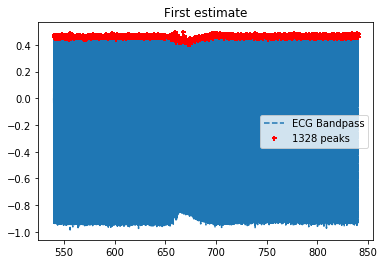

In [8]:
# Peak Detection
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
y = data['ECG Bandpass']
x = data['Time']
ind = find_peaks(data['ECG Bandpass'], height = 0.20, distance = 150)[0]
# distance in sample recorded

plt.plot(x, y, '--')
plt.plot(x[ind], y[ind], 'r+', ms=5, mew=2,
         label='{} peaks'.format(len(ind)))
plt.legend()
plt.title('First estimate')
plt.show()

### ECG Cleaning
Remove ectopic beats
Interpolate missing values using linear 
See https://github.com/Aura-healthcare/hrvanalysis/blob/master/hrvanalysis/preprocessing.py

RR intervals and NN intervals are synonymous, except NN denotes that the R peak is "normal". 

In [9]:
ect_ind = remove_ectopic_beats(ind)
nn_ind = interpolate_nan_values(rr_intervals=ect_ind) 

3 ectopic beat(s) have been deleted with malik rule.


In [10]:
time_domain_features = get_time_domain_features(nn_ind)

## Time Domain Measures

In [11]:
from hrvanalysis import get_time_domain_features, get_frequency_domain_features

get_time_domain_features(nn_ind)

{'mean_nni': 598119.4179216868,
 'sdnn': 346667.0985401979,
 'sdsd': 17.821092786065606,
 'nni_50': 1327,
 'pnni_50': 99.92469879518072,
 'nni_20': 1327,
 'pnni_20': 99.92469879518072,
 'rmssd': 903.5766626190839,
 'median_nni': 598053.5,
 'range_nni': 1198813.0,
 'cvsd': 0.0015106960843351042,
 'cvnni': 0.5795951245735811,
 'mean_hr': 0.46210929473311513,
 'max_hr': 135.13513513513513,
 'min_hr': 0.05003097751357716,
 'std_hr': 4.08278438491247}

In [12]:
get_frequency_domain_features(nn_ind)

{'lf': 19.511942183727093,
 'hf': 0.0069644417883194774,
 'lf_hf_ratio': 2801.651988311806,
 'lfnu': 99.96431950865929,
 'hfnu': 0.03568049134071605,
 'total_power': 166.94171560726068,
 'vlf': 147.42280898174528}

In [13]:
'''
def get_frequency_domain_features(nn_intervals: List[float], method: str = WELCH_METHOD,
                                  sampling_frequency: int = 4, interpolation_method: str = "linear",
                                  vlf_band: namedtuple = VlfBand(0.003, 0.04),
                                  lf_band: namedtuple = LfBand(0.04, 0.15),
                                  hf_band: namedtuple = HfBand(0.15, 0.40))
'''

# Function needs to be changed to match mice

'\ndef get_frequency_domain_features(nn_intervals: List[float], method: str = WELCH_METHOD,\n                                  sampling_frequency: int = 4, interpolation_method: str = "linear",\n                                  vlf_band: namedtuple = VlfBand(0.003, 0.04),\n                                  lf_band: namedtuple = LfBand(0.04, 0.15),\n                                  hf_band: namedtuple = HfBand(0.15, 0.40))\n'

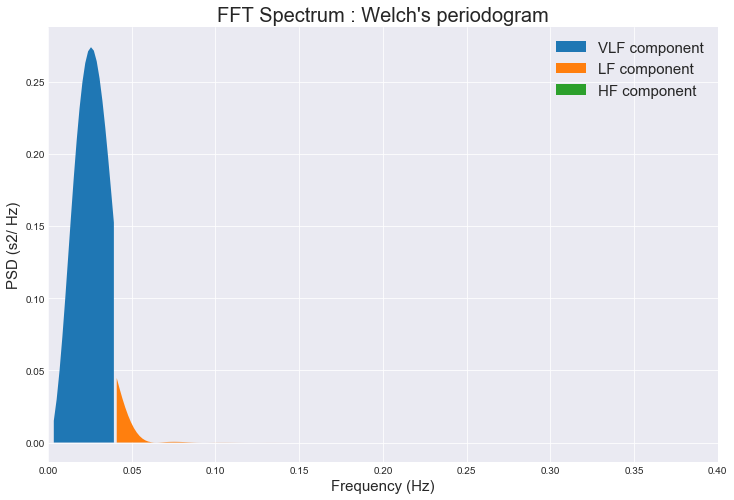

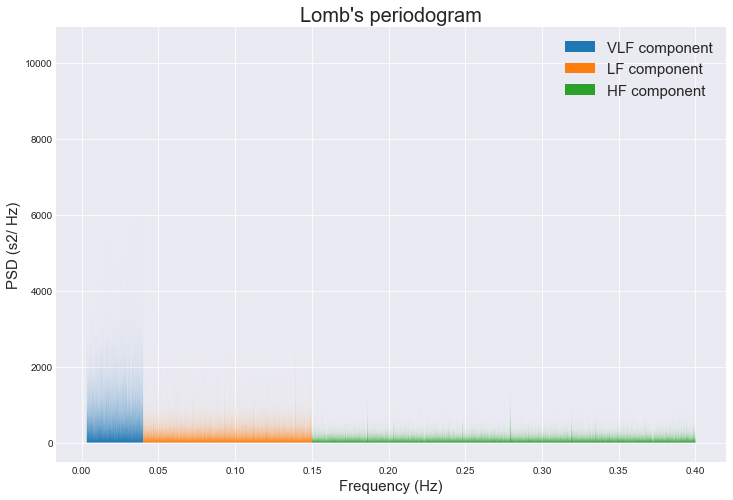

Wall time: 6.98 s


In [14]:
%%time
from hrvanalysis import plot_psd, plot_distrib

plot_psd(nn_ind, method="welch")
plot_psd(nn_ind, method="lomb")